In [10]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [11]:
# 確認是否有 GPU 可以使用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
# 假設您的資料在 'xss_data.xlsx'，第一個 column 是 XSS 負載，第二個 column 是標籤
df = pd.read_csv('../res/model/xss_dataset_evo1.csv', header=None, quotechar='"', escapechar='\\')
xss_payloads = df[0].tolist() # 第一欄為 XSS 負載
labels = df[1].tolist()       # 第二欄為標籤（0 或 1）

# xss_payloads = []
# labels = []
# with open('../res/model/xss_dataset.csv', 'r') as f:
#     for line in f:
#         idx = line.rfind(',')
#         if idx != -1:
#             payload = line[:idx].strip()
#             label = int(line[idx + 1:].strip())
#             xss_payloads.append(payload)
#             labels.append(label)

def preprocess_payload(payload):
    def replace_url(text):
        text = re.sub(r'http[s]?://[^\s"<>]+', 'http://u', text)
        text = re.sub(r'ftp://[^\s"<>]+', 'http://u', text)
        text = re.sub(r'mailto:[^\s"<>]+', 'http://u', text)
        text = re.sub(r'file://[^\s"<>]+', 'http://u', text)
        text = re.sub(r'tel:[^\s"<>]+', 'http://u', text)
        text = re.sub(r'data:[^\s"<>]+', 'http://u', text)
        text = re.sub(r'(href|src|action|formaction|background)=[\'"][^\s"<>]+[\'"]', r'\1="http://u"', text)
        text = re.sub(r'srcset="([^"]+)"', lambda match: 'srcset="r"', text)
    
        return text

    # 替換數字為單個 0
    def replace_numbers(text):
        return re.sub(r'\d+', '0', text)  # 使用 \d+ 確保每組數字只替換為一個 0

    # 保留 HTML 標籤並處理內容
    def process_tag(match):
        tag_content = match.group(0)
        # 替換標籤內的 URL
        tag_content = replace_url(tag_content)
        # 替換標籤內的數字
        tag_content = replace_numbers(tag_content)
        return tag_content

    # 使用正則表達式匹配 HTML 標籤並處理
    processed_payload = re.sub(r'<[^>]+>', process_tag, payload)
        
    # 處理標籤外的數字和 URL
    processed_payload = replace_url(processed_payload)
    processed_payload = replace_numbers(processed_payload)
        
    return processed_payload

def custom_tokenize(text):
    # 定義正則表達式規則
    pattern = r'''(?x)                         # 開啟 verbose 模式，讓正則表達式更易讀
        "[^"]+"                                # 匹配雙引號內的內容
        | '[^']+'                              # 匹配單引號內的內容
        | http://\w+                           # 匹配 http:// 開頭的 URL
        | <\w+>                                # 匹配開啟的 HTML 標籤 <tag>
        | </\w+>                               # 匹配關閉的 HTML 標籤 </tag>
        | \w+=                                 # 匹配像 name=value 這樣的結構
        | [\w\.]+                              # 匹配普通單詞（字母、數字、下劃線或點）
        | [\s]+                                # 匹配空白字符
        | [^\w\s<>]+                           # 匹配非字母數字空白和非標籤的其他字符
    '''
        
    # 使用正則表達式分詞
    tokens = re.findall(pattern, text)
        
    # 清除多餘的空格字符
    tokens = [token.strip() for token in tokens if token.strip()]
        
    return tokens

# 對所有 XSS 負載進行預處理
processed_payloads = [preprocess_payload(payload) for payload in xss_payloads]

# 分詞
tokens = [custom_tokenize(text) for text in processed_payloads]

In [13]:
# 計算 TF-IDF 並篩選前 3000 詞彙
vectorizer = TfidfVectorizer(max_features=3000)  # 選擇前 3000 個高 TF-IDF 的詞
tfidf_matrix = vectorizer.fit_transform([' '.join(tokens_list) for tokens_list in tokens])
selected_words = vectorizer.get_feature_names_out()

# 篩選詞彙表，更新 tokens
tered_tokensfil = [
    [token if token in selected_words else 'UNK' for token in tokens_list] 
    for tokens_list in tokens
]

In [14]:
# 使用 Word2Vec 訓練詞向量模型 embedding size 設定為 128
model = Word2Vec(tered_tokensfil, vector_size=128, window=2, min_count=10, sg=1)  # sg=1 表示使用 Skip-gram 模型

# 測試模型：查看某些詞的詞向量
#print(model.wv['</sup>'])

print(model.wv.most_similar('alert'))

# 將前 3000 個詞跟對應向量寫入 res/TFIDF_top3000.txt
with open('../res/TFIDF_top3000.txt', 'w') as f1, open('../res/model_word.txt', 'w') as f2:
    for word in selected_words:
        f1.write(word + ' ')
        if word in model.wv:
            f2.write(word + ' ')

[('test', 0.8516242504119873), ('autofocus', 0.8116831183433533), ('th', 0.720637321472168), ('input', 0.7183848023414612), ('contenteditable', 0.711481511592865), ('here', 0.7013234496116638), ('drag', 0.6906923651695251), ('color', 0.6871994733810425), ('me', 0.6788023114204407), ('drop', 0.6767927408218384)]


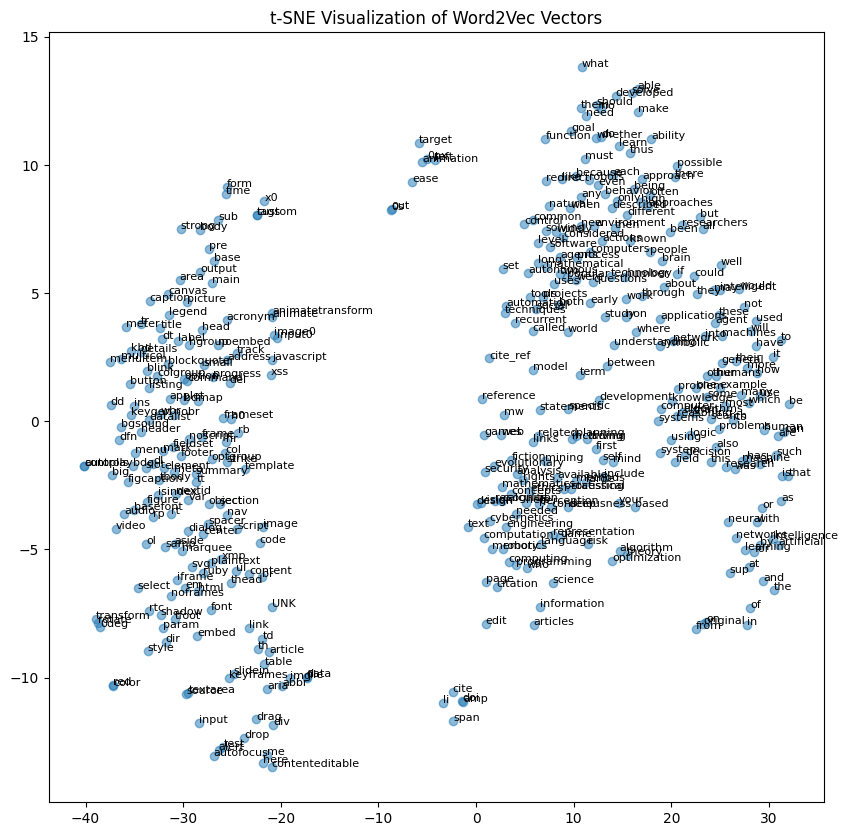

In [15]:
# 提取所有詞彙及其對應的詞向量
words = list(model.wv.index_to_key)  # 取得所有詞彙
word_vectors = np.array([model.wv[word] for word in words])  # 取得每個詞的詞向量

# 使用 t-SNE 進行降維
tsne = TSNE(n_components=2, random_state=42)  # 降維到 2 維
reduced_vectors = tsne.fit_transform(word_vectors)

# 可視化
plt.figure(figsize=(10, 10))
plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], alpha=0.5)

# 顯示每個詞的位置
for i, word in enumerate(words):
    plt.annotate(word, (reduced_vectors[i, 0], reduced_vectors[i, 1]), fontsize=8)

plt.title('t-SNE Visualization of Word2Vec Vectors')
plt.show()

In [16]:
def tokens_to_vectors(tered_tokensfil, model, max_sequence_length=100):
    vectors = []
    
    for token in tered_tokensfil:
        if token in model.wv:
            vectors.append(torch.tensor(model.wv[token], dtype=torch.float32))  # 轉為 PyTorch Tensor
        else:
            vectors.append(torch.zeros(model.vector_size, dtype=torch.float32))  # 未知詞補零

    vectors = torch.stack(vectors) if vectors else torch.zeros((0, model.vector_size), dtype=torch.float32)  

    # 進行 padding 或截取，確保 shape = (max_sequence_length, embedding_dim)
    if vectors.shape[0] < max_sequence_length:
        pad_size = max_sequence_length - vectors.shape[0]
        padding_tensor = torch.zeros((pad_size, model.vector_size), dtype=torch.float32)
        vectors = torch.cat([vectors, padding_tensor], dim=0)
    else:
        vectors = vectors[:max_sequence_length]  # 超過 max_sequence_length 則截斷

    return vectors

# 轉換所有 tokens
xss_vectors = [tokens_to_vectors(token_list, model) for token_list in tokens]

# 堆疊成 batch
xss_vectors_padded = torch.stack(xss_vectors)  # (batch_size, max_sequence_length, embedding_dim)

print(xss_vectors_padded.shape)  # (batch_size, 100, 128)

torch.Size([13686, 100, 128])


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class XSSClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, max_seq_len):
        super(XSSClassifier, self).__init__()
        
        # CNN 層
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=6, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=input_dim, out_channels=4, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=input_dim, out_channels=2, kernel_size=3, padding=1)
        
        # BiLSTM 層
        self.lstm = nn.LSTM(input_size=12, hidden_size=64, batch_first=True, bidirectional=True)
        
        # Self-Attention 層
        self.attention = nn.Linear(128, 1)
        
        # MaxPooling & UpSampling
        self.maxpool = nn.MaxPool1d(kernel_size=2)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(140 * max_seq_len, 128)
        self.fc2 = nn.Linear(128, output_dim)
        self.dropout = nn.Dropout(0.5)

    def attention_layer(self, lstm_out):
        attn_scores = torch.tanh(self.attention(lstm_out))  # (batch, seq_len, 1)
        attn_weights = torch.softmax(attn_scores, dim=1)  # 計算權重
        attn_out = lstm_out * attn_weights  # 加權輸出
        return attn_out
 
    def forward(self, x):
        # 調整維度 (batch, seq_len, embedding_dim) → (batch, embedding_dim, seq_len)
        x = x.permute(0, 2, 1)
        
        # CNN
        conv1_out = F.relu(self.conv1(x))
        conv2_out = F.relu(self.conv2(x))
        conv3_out = F.relu(self.conv3(x))
        
        # 串接 CNN 特徵
        conv_out = torch.cat([conv1_out, conv2_out, conv3_out], dim=1)  # (batch, 12, seq_len)
        
        # 調整維度以適應 LSTM (batch, seq_len, 12)
        conv_out = conv_out.permute(0, 2, 1)
        
        # BiLSTM
        lstm_out, _ = self.lstm(conv_out)
        
        # Self-Attention
        attn_out = self.attention_layer(lstm_out)
        
        # MaxPooling + UpSampling
        pooled_out = self.maxpool(attn_out.permute(0, 2, 1))  # 變成 (batch, channels, seq_len//2)
        upsampled_out = self.upsample(pooled_out)  # 放大回原本大小 (batch, channels, seq_len)
        
        # 特徵融合
        final_features = torch.cat([conv_out, upsampled_out.permute(0, 2, 1)], dim=-1)  # (batch, seq_len, 128)
        
        # 展平成全連接層輸入
        flattened = final_features.view(final_features.size(0), -1)
        
        # Dropout + 全連接層
        fc1_out = F.relu(self.fc1(flattened))
        fc1_out = self.dropout(fc1_out)
        output = self.fc2(fc1_out)

        return output


In [ ]:
# 將 labels 轉換為 one-hot 編碼
labels = torch.tensor(labels, dtype=torch.long)  # PyTorch 使用 LongTensor 作為分類標籤
y_one_hot = F.one_hot(labels, num_classes=2).float()  # One-hot 編碼轉為 float32

# 分割數據集（8:2）
x_train, x_temp, y_train, y_temp = train_test_split(xss_vectors_padded, y_one_hot, test_size=0.2, random_state=42)

# 再次分割成驗證集與測試集（各 10%）
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

# 創建 DataLoader
batch_size = 12
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 設定設備（GPU or CPU）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 初始化模型
model = XSSClassifier(128, 64, 2, 100) 
model.to(device)  # 移到 GPU 或 CPU

# 損失函數 & 優化器
criterion = torch.nn.CrossEntropyLoss()  # PyTorch 用 CrossEntropyLoss，不需要 one-hot
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6)

# 訓練函式
num_epochs = 30
early_stopping_patience = 10
best_val_loss = float('inf')
early_stopping_counter = 0

train_acc_history, val_acc_history = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss, correct, total = 0.0, 0, 0
    
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch.argmax(dim=1))  # CrossEntropyLoss 需要標籤索引
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x_batch.size(0)
        correct += (outputs.argmax(dim=1) == y_batch.argmax(dim=1)).sum().item()
        total += x_batch.size(0)

    train_loss /= total
    train_acc = correct / total
    train_acc_history.append(train_acc)

    # 驗證
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch.argmax(dim=1))
            
            val_loss += loss.item() * x_batch.size(0)
            correct += (outputs.argmax(dim=1) == y_batch.argmax(dim=1)).sum().item()
            total += x_batch.size(0)

    val_loss /= total
    val_acc = correct / total
    val_acc_history.append(val_acc)

    # 學習率調整
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), "../res/best_model_evo1.pth")  # 儲存最佳模型
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping triggered!")
            break

Epoch 1/30, Train Loss: 0.0768, Train Acc: 0.9797, Val Loss: 0.0515, Val Acc: 0.9869
Epoch 2/30, Train Loss: 0.0544, Train Acc: 0.9868, Val Loss: 0.0488, Val Acc: 0.9876
Epoch 3/30, Train Loss: 0.0524, Train Acc: 0.9869, Val Loss: 0.0495, Val Acc: 0.9869
Epoch 4/30, Train Loss: 0.0502, Train Acc: 0.9872, Val Loss: 0.0485, Val Acc: 0.9876
Epoch 5/30, Train Loss: 0.0495, Train Acc: 0.9871, Val Loss: 0.0489, Val Acc: 0.9876
Epoch 6/30, Train Loss: 0.0484, Train Acc: 0.9872, Val Loss: 0.0479, Val Acc: 0.9876
Epoch 7/30, Train Loss: 0.0504, Train Acc: 0.9868, Val Loss: 0.0478, Val Acc: 0.9876
Epoch 8/30, Train Loss: 0.0478, Train Acc: 0.9871, Val Loss: 0.0479, Val Acc: 0.9883
Epoch 9/30, Train Loss: 0.0470, Train Acc: 0.9874, Val Loss: 0.0482, Val Acc: 0.9883
Epoch 10/30, Train Loss: 0.0485, Train Acc: 0.9872, Val Loss: 0.0490, Val Acc: 0.9883
Epoch 11/30, Train Loss: 0.0473, Train Acc: 0.9874, Val Loss: 0.0489, Val Acc: 0.9883
Epoch 12/30, Train Loss: 0.0457, Train Acc: 0.9874, Val Loss: 0

In [ ]:
# 測試
model.load_state_dict(torch.load("../res/best_model_evo1.pth"))  # 載入最佳模型
model.eval()
test_loss, correct, total = 0.0, 0, 0
TP, TN, FP, FN = 0, 0, 0, 0

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch.argmax(dim=1))

        test_loss += loss.item() * x_batch.size(0)

        # 計算 TP, TN, FP, FN
        preds = outputs.argmax(dim=1)
        true_labels = y_batch.argmax(dim=1)
        TP += ((preds == 1) & (true_labels == 1)).sum().item()
        TN += ((preds == 0) & (true_labels == 0)).sum().item()
        FP += ((preds == 1) & (true_labels == 0)).sum().item()
        FN += ((preds == 0) & (true_labels == 1)).sum().item()

        correct += (outputs.argmax(dim=1) == y_batch.argmax(dim=1)).sum().item()
        total += x_batch.size(0)

test_loss /= total
test_acc = correct / total
print(f"Test Accuracy: {test_acc:.4f}")
print(f"True Positives rate: {TP / (TP + TN + FP + FN)}")
print(f"True Negatives rate: {TN / (TP + TN + FP + FN)}")
print(f"False Positives rate: {FP / (TP + TN + FP + FN)}")
print(f"False Negatives rate: {FN / (TP + TN + FP + FN)}")
print(f"Accuracy: {TP + TN} / {TP + TN + FP + FN} = {(TP + TN) / (TP + TN + FP + FN)}")
print(f"Precision: {TP / (TP + FP) if (TP + FP) > 0 else 0}")
print(f"Recall: {TP / (TP + FN) if (TP + FN) > 0 else 0}")
print(f"F1 Score: {2 * TP / (2 * TP + FP + FN) if (2 * TP + FP + FN) > 0 else 0}")

Test Accuracy: 0.9890
True Positives rate: 0.5420014609203798
True Negatives rate: 0.44704163623082543
False Positives rate: 0.0
False Negatives rate: 0.01095690284879474
Accuracy: 1354 / 1369 = 0.9890430971512053
Precision: 1.0
Recall: 0.9801849405548216
F1 Score: 0.989993328885924


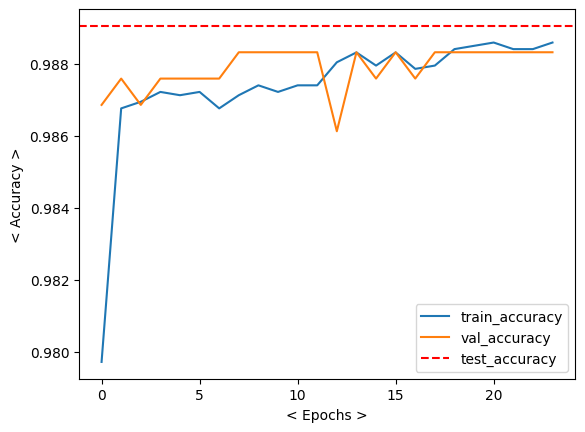

In [20]:
import matplotlib.pyplot as plt

# 繪製訓練與驗證準確度
plt.plot(train_acc_history, label='train_accuracy')
plt.plot(val_acc_history, label='val_accuracy')

# 在訓練完成後，使用測試集計算測試準確度
plt.axhline(y=test_acc, color='r', linestyle='--', label='test_accuracy')

plt.xlabel('< Epochs >')
plt.ylabel('< Accuracy >')
plt.legend()
plt.show()
